In [81]:
import itertools
import numpy as np
import qiskit
from qiskit import QuantumCircuit,QuantumRegister, circuit, converters
from qiskit.circuit.library.standard_gates import XGate
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.bit import *

# Grover's algorithm applied to a satisfiability problem
 
 The 3-SAT problem is a well known NP-complete problem. It consists in looking for vectors : $$(x_0, . . . , x_{n-1}) \in \{0, 1\}^n$$
satisfying a given predicate f in the form of a conjunction of clauses
which are all 3-disjunctions.

### answer 0 :

We condider the the predicate f defined as : 
$$f(x_0,x_1,x_2,x_3,x_4) = (\overline{x_0}\cup x_1)\cap(x_0\cup x_1 \cup \overline{x_2})\cap(x_2\cup x_3)\cap(\overline{x_1}\cup\overline{x_2}\cup x_3)\cap(\overline{x_3}\cup \overline{x_4})\cap(\overline{x_2}\cup \overline{x_3}\cup x_4)$$
There are 3 possible solutions :
$$v_1 = (0, 0, 0, 1, 0)\qquad v_2 = (0, 1, 0, 1, 0) \qquad v_3 = (1, 1, 0, 1, 0)$$

We get this through this code:

In [82]:
def compute(n, expr):
    combinations = list(itertools.product([0, 1], repeat=n))
    
    matrix = np.array(combinations)
    res = [expr(x) for x in matrix]
    print([matrix[x] for x in range(np.power(2,n)) if res[x] == True])

In [83]:
def custom_expression(x):
    return (
        (not x[0] or x[1]) and
        (x[0] or x[1] or not x[2]) and
        (x[2] or x[3]) and
        (not x[1] or not x[2] or x[3]) and
        (not x[3] or not x[4]) and
        (not x[2] or not x[3] or x[4])
    )
compute(5, custom_expression)

[array([0, 0, 0, 1, 0]), array([0, 1, 0, 1, 0]), array([1, 1, 0, 1, 0])]


### answer 1 :

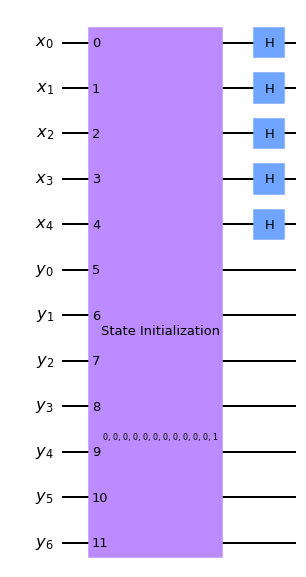

In [84]:
f_in = QuantumRegister(5, name='x')
y = QuantumRegister(7, name='y')

state_prep = QuantumCircuit(f_in, y)
state_prep.prepare_state('000000000001', state_prep.qubits, label='State Initialization')

for i in range(5):
    state_prep.h(i)
    
state_prep.draw('mpl')

### answer 2 :

An OR gate can be written using only X and CNOT gates:

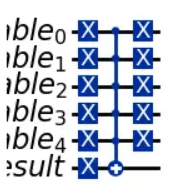

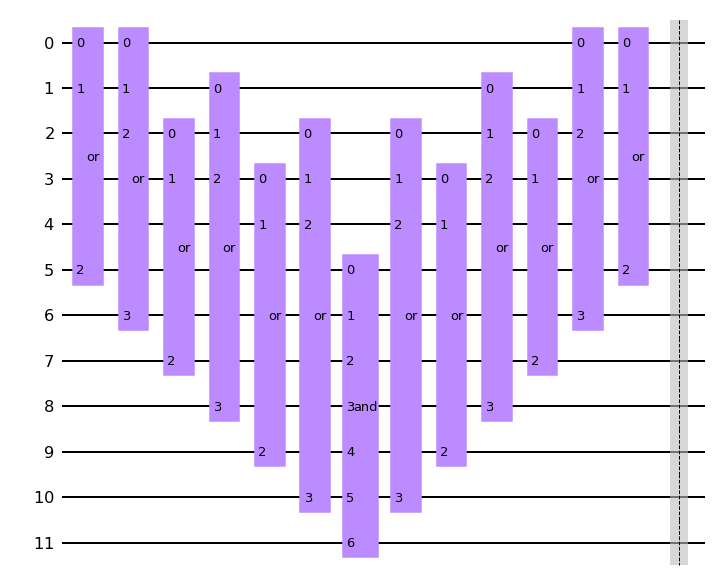

In [85]:
oracle_gate = QuantumCircuit(state_prep.qubits)

# these clauses include the negation of the qubit
clause_1 = circuit.library.OR(2, [-1,1])
clause_2 = circuit.library.OR(3, [1,1,-1])
clause_3 = circuit.library.OR(2, [1,1])
clause_4 = circuit.library.OR(3, [-1,-1,1])
clause_5 = circuit.library.OR(2, [-1,-1])
clause_6 = circuit.library.OR(3, [-1,-1,1])
and_grouping = circuit.library.AND(6, [1,1,1,1,1,1])

qubits = np.array(oracle_gate.qubits)

oracle_gate = oracle_gate.compose(clause_1, qubits=qubits.take([0,1,5]))
oracle_gate = oracle_gate.compose(clause_2, qubits=qubits.take([0,1,2,6]))
oracle_gate = oracle_gate.compose(clause_3, qubits=qubits.take([2,3,7]))
oracle_gate = oracle_gate.compose(clause_4, qubits=qubits.take([1,2,3,8]))
oracle_gate = oracle_gate.compose(clause_5, qubits=qubits.take([3,4,9]))
oracle_gate = oracle_gate.compose(clause_6, qubits=qubits.take([2,3,4,10]))

oracle_gate = oracle_gate.compose(and_grouping, qubits=qubits[5:12])

oracle_gate = oracle_gate.compose(clause_6, qubits=qubits.take([2,3,4,10]))
oracle_gate = oracle_gate.compose(clause_5, qubits=qubits.take([3,4,9]))
oracle_gate = oracle_gate.compose(clause_4, qubits=qubits.take([1,2,3,8]))
oracle_gate = oracle_gate.compose(clause_3, qubits=qubits.take([2,3,7]))
oracle_gate = oracle_gate.compose(clause_2, qubits=qubits.take([0,1,2,6]))
oracle_gate = oracle_gate.compose(clause_1, qubits=qubits.take([0,1,5]))

oracle_gate.barrier()
oracle_gate.draw('mpl')

In [86]:
# # run only the above circuit with the vectors that satisfy the expression
# state_prep_special = QuantumCircuit(f_in, y)
# state_prep_special.prepare_state('000000000010', state_prep_special.qubits, label='State Initialization')

# circuit_special = state_prep_special.compose(oracle_gate)
# circuit_special.measure_all()
# circuit_special.draw('mpl')

# sim_ideal = AerSimulator()

# job_ideal = sim_ideal.run(state_prep_special)
# result_ideal = job_ideal.result()
# statevector_ideal = result_ideal.data(10)

# print(statevector_ideal)

# # 

### answer 3 :

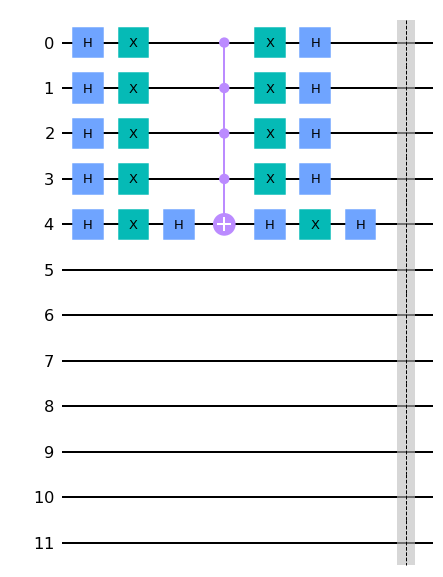

In [102]:
reflection_gate = QuantumCircuit(state_prep.qubits)

for i in range(5):
    reflection_gate.h(i)
    reflection_gate.x(i)
    
reflection_gate.h(4)
c3h_gate = XGate().control(4)
reflection_gate.append(c3h_gate, state_prep.qubits[:5] )
reflection_gate.h(4)

for i in range(5):
    reflection_gate.x(i)
    reflection_gate.h(i)
    
reflection_gate.barrier()
reflection_gate.draw('mpl')

### answer 4 :

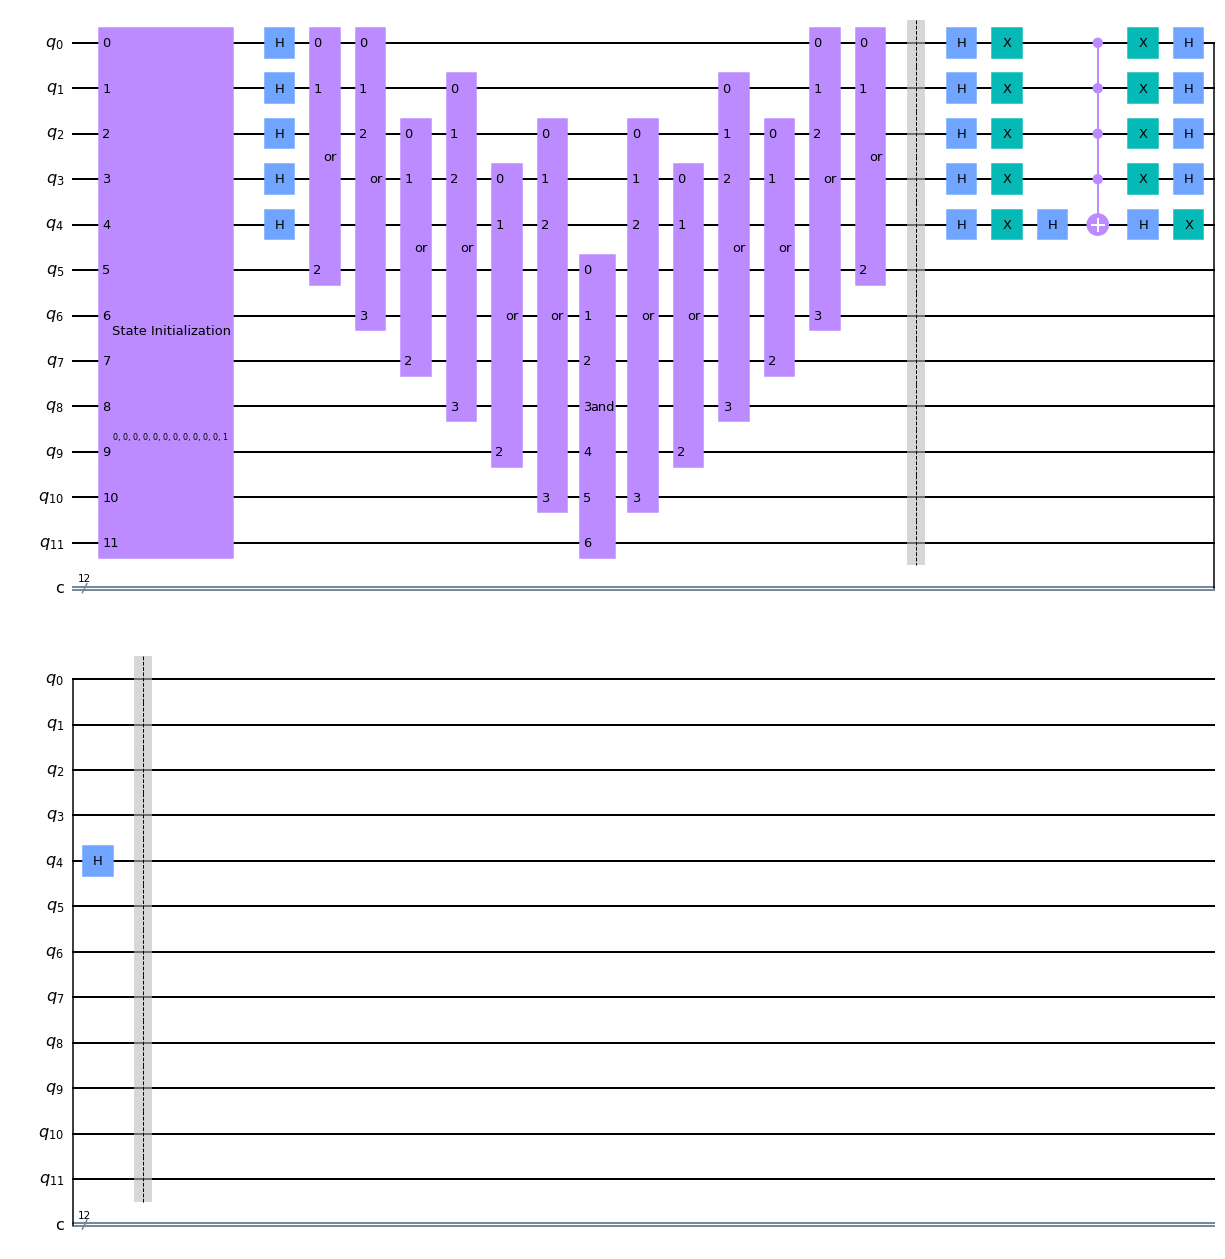

In [179]:
full_circuit = QuantumCircuit(len(state_prep.qubits), len(state_prep.qubits))

full_circuit = full_circuit.compose(state_prep).compose(oracle_gate).compose(reflection_gate)

full_circuit.draw('mpl')

In [180]:
sim_ideal = AerSimulator()  # construct simulator

K = 10

circuits = []
circuits.append(full_circuit)

for k in range(1,K):
    circuits.append(circuits[-1].compose(oracle_gate).compose(reflection_gate))

print(type(full_circuit.qubits))
for circ in circuits:
    circ = circ.measure(full_circuit.qubits[:5] + [full_circuit.qubits[-1]], full_circuit.clbits[:6])
#circuits = [circ.measure(full_circuit.qubits[:5], full_circuit.clbits[:5]) for circ in circuits ]



<class 'list'>


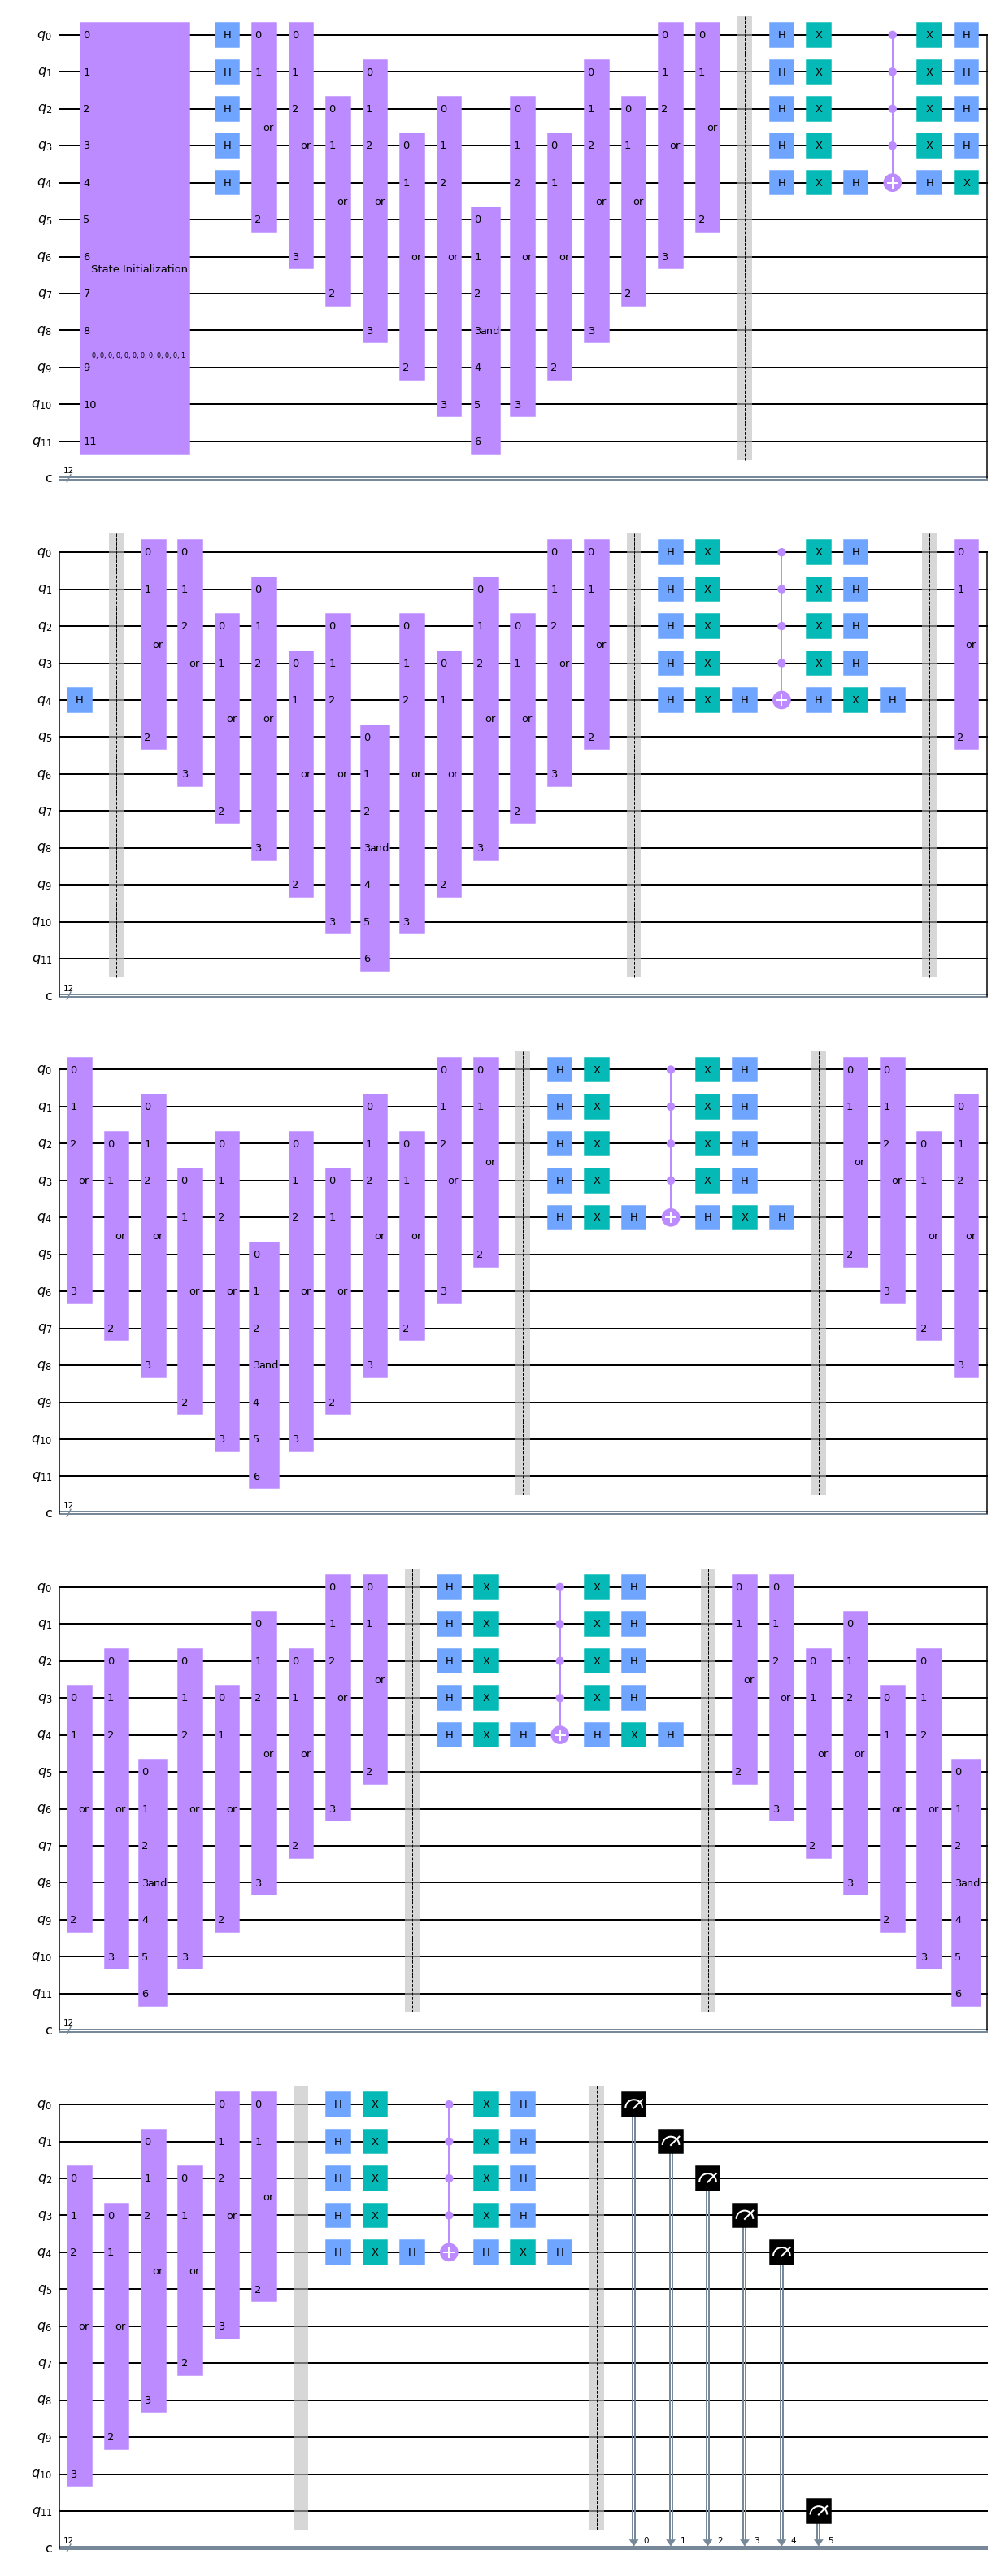

In [181]:
circuits[4].draw('mpl')

In [163]:
counts = np.empty(K,dtype=object)
for i in range(K):
    job_ideal = sim_ideal.run(transpile(circuits[i], sim_ideal), shots=2000)  # launch a job to run the circuit multiple times
    res_ideal = job_ideal.result()  # obtain results of a run
    counts[i] = res_ideal.get_counts()  # obtain results of the measumerents

In [164]:
# plot_histogram(counts[14]) # change K to 14 to plot 14 iterations

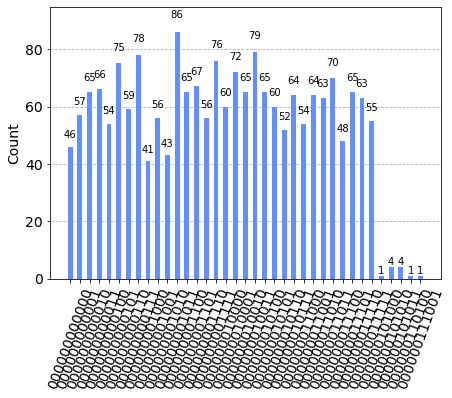

In [165]:
plot_histogram(counts[1])

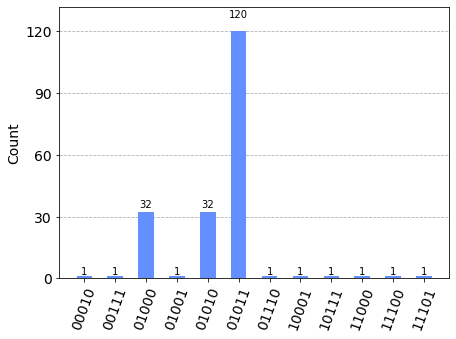

In [166]:
plot_histogram({key[7:]: value for key, value in counts[2].items() if key[6].startswith('1')})

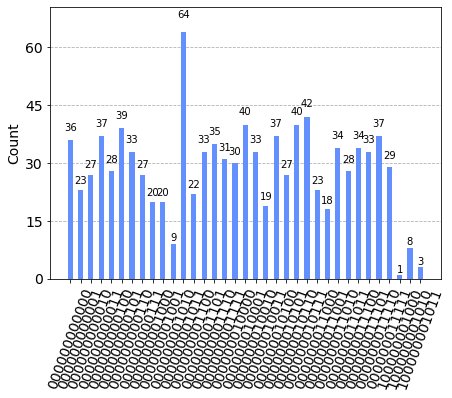

In [135]:
plot_histogram(counts[3])

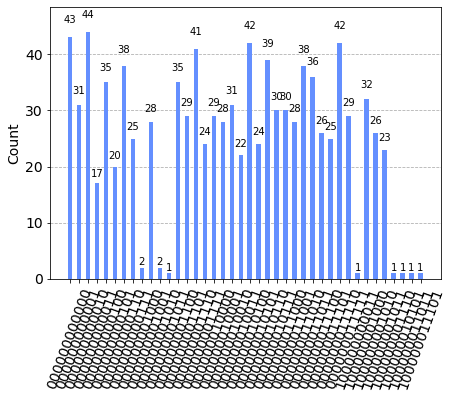

In [49]:
plot_histogram(counts[4])

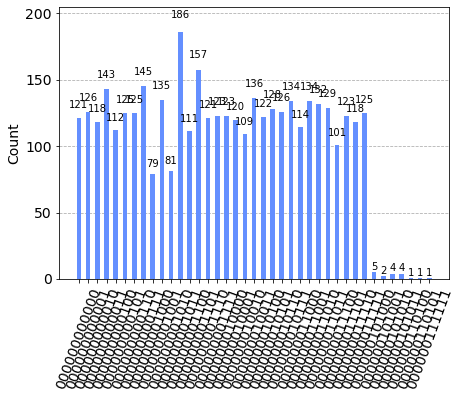

In [177]:
# run with noise
from qiskit_aer.noise import NoiseModel

# noise_model = NoiseModel.from_backend(sim_ideal.backend)
sim_noise = AerSimulator(noise_model=NoiseModel())

counts_noise = np.empty(K,dtype=object)
for i in range(K):
    job_noise = sim_noise.run(transpile(circuits[i], sim_noise), shots=4000) 
    res_noise = job_noise.result()  
    counts_noise[i] = res_noise.get_counts()  

plot_histogram(counts_noise[1])

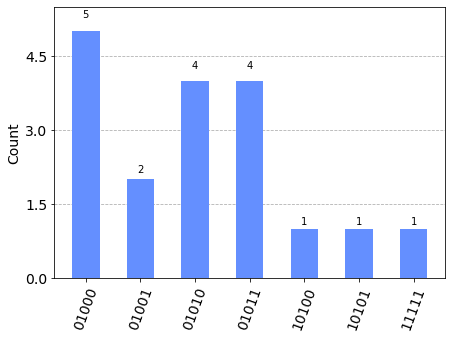

In [178]:
plot_histogram({key[7:]: value for key, value in counts_noise[1].items() if key[6].startswith('1')})

In [182]:
backend_true = service.least_busy(operational=True, simulator=False, min_num_qubits=12)
from qiskit import transpile

isa_circ_with_h = transpile(circuits[0:10], backend_true)

In [ ]:
job_true = backend_true.run(isa_circ_with_h, shots=4000)
res_true = job_true.result()

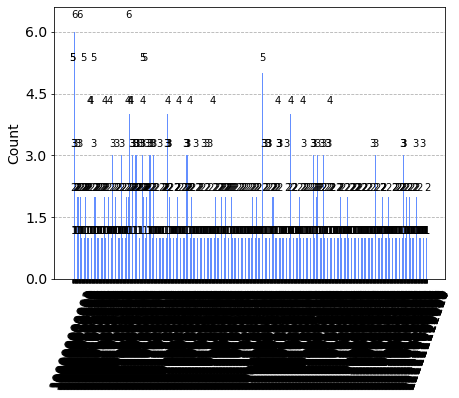

In [56]:
plot_histogram({key[7:]: value for key, value in res_true.get_counts()[0].items() if key[6].startswith('1')}

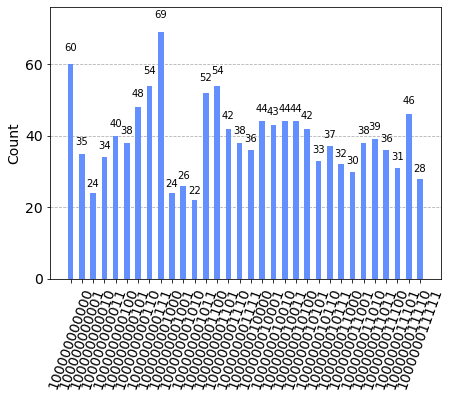

In [79]:
from collections import defaultdict

data = res_true.get_counts()[1]

def modify_key(key):
    return key[0] + '000000' + key[7:]

# Create a defaultdict to aggregate values for keys
modified_data = defaultdict(int)
for key, value in data.items():
    modified_key = modify_key(key)
    modified_data[modified_key] += value

# Sort the dictionary by values
sorted_data = dict(sorted(modified_data.items(), key=lambda item: item[1], reverse=True))

plot_histogram({key: value for key, value in sorted_data.items() if key.startswith('1')})

### answer 5:

From the question 0, we get M = 3, the number of solutions of 3-SAT, and N = 2⁵, the number of possible differents inputs.

The initial angle $\theta_0$ is given by the relation : 
$$ \theta_0 \approx \sin(\theta_0) = \sqrt{\frac{M}{N}} = \sqrt{\frac{3}{32}} \approx 0.306$$ 

The number of iteration of the Grover algorithm to find the result of 3-SAT with the best probability is given by the relation : 
$$ sin((2k+1)\theta_0) = 1 \implies (2k+1)\theta_0 = \pi/2 \implies k =  \frac{\frac{\pi}{2\theta_0} -1}{2}\approx 2.06$$
As k is the number of interration of our circuit, k must be integer. Then the circuit should be run $\textbf{2 times}$ to have an output with the higher probability to be true.